# Directed KV Cache: Comprehensive Surrogate Routing Experiment

## Objective

Comprehensive evaluation of **surrogate-primed KV caches** across multiple strategies:
truncated + RoPE-corrected caches, full-context caches, and key controls.

### Motivation from Prior Experiments

The `directed_kvcache_experiment` (200 samples, 15 conditions) produced these findings:

1. **RoPE correction works mechanically** — it fully recovers from the catastrophic
   damage of naive truncation (NLL 2.58 → 1.24), but corrected truncated caches
   merely return to baseline, never beating it.
2. **Full-context surrogates DO help** — keeping the surrogate visible during inference
   significantly improves NLL (win rate ~71%, p < 1e-10).
3. **Random prefix also helps** — a random token prefix kept in full context achieved
   77% win rate, suggesting the benefit may be positional/structural rather than semantic.
4. **Bare document (no "Document:\n") is best** — removing the framing label gave the
   lowest NLL overall.

This experiment scales these findings to 500 samples with 5+5 surrogate routing to
determine whether the patterns hold at scale and whether routing among surrogates
captures additional value.

### Experimental Conditions

| Condition | Description |
|-----------|-------------|
| **Baseline** | Document cached with framing (`"Document:\n{document}"`) |
| **Bare Document** | Document cached without framing (raw text only) |
| **Truncated + Corrected (5 gen + 5 static + perfect)** | Surrogate primed, truncated, RoPE corrected |
| **Full Context (routed gen + routed static + perfect)** | Surrogate kept visible during inference |
| **Full Context Random** | Random token prefix kept visible (positional control) |
| **Routed / Oracle** | Best surrogate selected by similarity / by NLL |

### Key Questions

1. At 500-sample scale, do truncated+corrected caches ever beat baseline?
2. Does full-context surrogate routing provide consistent improvement?
3. Is the full-context improvement semantic (surrogate content matters) or positional
   (any prefix helps equally)?
4. Does the perfect surrogate condition separate these hypotheses?

## Step 1: Setup

In [1]:
import sys
import os
import json
import time
import datetime
from typing import Dict, List, Any, Optional

import torch
import numpy as np
from tqdm.auto import tqdm
from scipy import stats
import matplotlib.pyplot as plt

# Ensure lib is importable
sys.path.insert(0, '.')

from lib import (
    ExperimentConfig,
    build_kv_cache,
    score_answer_with_cache,
    extract_and_truncate_cache,
    build_truncated_kv_cache,
    correct_rope_positions,
    build_truncated_kv_cache_corrected,
    generate_all_5_surrogates,
    compute_similarity,
    load_evaluation_samples,
    load_ms_marco,
    TOP_5_SURROGATE_TEMPLATES,
    STATIC_SURROGATE_QUERIES,
    analyze_experiment_results,
)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA L4
GPU Memory: 23.6 GB


In [2]:
# Configuration
config = ExperimentConfig(
    num_samples=1000,
    min_passage_words=50,
    max_passage_words=300,
    surrogate_max_tokens=45,
    surrogate_temperature=0.3,
    seed=42,
)

print(f"Model: {config.model_name}")
print(f"Samples: {config.num_samples}")
print(f"Passage words: {config.min_passage_words}-{config.max_passage_words}")
print(f"Device: {config.device}")

Model: mistralai/Mistral-7B-Instruct-v0.2
Samples: 1000
Passage words: 50-300
Device: cuda


## Step 2: Load Model, Tokenizer, and Embedding Model

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer

# Set seeds
torch.manual_seed(config.seed)
np.random.seed(config.seed)

# Load model (4-bit quantized)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

print(f"Loading {config.model_name}...")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
model = AutoModelForCausalLM.from_pretrained(
    config.model_name,
    quantization_config=bnb_config,
    device_map="auto",
)
model.eval()
print(f"Model loaded on {config.device}")

# Load embedding model for routing
print(f"Loading embedding model: {config.embedding_model_name}")
embed_model = SentenceTransformer(config.embedding_model_name)
print("Embedding model loaded.")

Loading mistralai/Mistral-7B-Instruct-v0.2...


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

Model loaded on cuda
Loading embedding model: all-MiniLM-L6-v2


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding model loaded.


## Step 3: Load Dataset

In [4]:
dataset = load_ms_marco(config)
samples = load_evaluation_samples(dataset, config, require_answer=True)
print(f"Loaded {len(samples)} evaluation samples")

# Quick sanity check
s = samples[0]
print(f"\nExample sample:")
print(f"  Query: {s['query'][:80]}...")
print(f"  Passage: {s['passage'][:80]}...")
print(f"  Answer: {s['answer'][:80]}")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'microsoft/ms_marco' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading microsoft/ms_marco dataset...
Dataset loaded: 10047 samples
Filtering samples...


Filtering:   0%|          | 0/10047 [00:00<?, ?it/s]

Selected 1000 samples
Loaded 1000 evaluation samples

Example sample:
  Query: what foods other than dairy products contain calcium...
  Passage: • Almonds. Almonds contain more calcium than any other nut, and they are also go...
  Answer: 1 Spinach. 2 Kale. 3 Okra. 4 Collards. 5 Soybeans. 6 White beans. 7 Some fish li


## Step 4: Surrogate Templates

We use 5 LLM-generated (document-specific) and 5 static (document-agnostic) surrogate queries.

In [5]:
print("=" * 80)
print("GENERATED SURROGATE TEMPLATES (document-specific, LLM-guided)")
print("=" * 80)
for key, tmpl in TOP_5_SURROGATE_TEMPLATES.items():
    print(f"  {key:30s} -> {tmpl['name']}")

print()
print("=" * 80)
print("STATIC SURROGATE QUERIES (same for all documents)")
print("=" * 80)
for key, info in STATIC_SURROGATE_QUERIES.items():
    print(f"  {key:30s} -> \"{info['query']}\"")

GENERATED SURROGATE TEMPLATES (document-specific, LLM-guided)
  target_question                -> Target Natural Language Question
  keyword_query                  -> Keyword-ese Query
  symptom_scenario               -> Symptom/Scenario Query
  misconception_negative         -> Misconception/Negative Query
  messy_realworld                -> Messy Real-World Query

STATIC SURROGATE QUERIES (same for all documents)
  static_definitional            -> "What is this and what does it mean?"
  static_procedural              -> "How do I do this step by step?"
  static_quantitative            -> "How much does this cost or how long does it take?"
  static_factual                 -> "What are the key facts I need to know?"
  static_problem                 -> "What problem does this solve?"


## Step 5: Test on One Sample

Verify the full pipeline works before running the main loop.

In [6]:
# Generate surrogates for the first sample
test_sample = samples[0]
print(f"Passage: {test_sample['passage'][:120]}...")
print(f"Query:   {test_sample['query']}")
print(f"Answer:  {test_sample['answer'][:80]}")
print()

test_surrogates = generate_all_5_surrogates(
    test_sample['passage'], model, tokenizer, config
)
print("Generated surrogates:")
for key, surr in test_surrogates.items():
    sim = compute_similarity(surr, test_sample['query'], embed_model)
    print(f"  {key:30s} -> \"{surr}\" (sim={sim:.3f})")

print()
print("Static surrogates:")
for key, info in STATIC_SURROGATE_QUERIES.items():
    sim = compute_similarity(info['query'], test_sample['query'], embed_model)
    print(f"  {key:30s} -> \"{info['query']}\" (sim={sim:.3f})")

# Test baseline cache
baseline_ctx = config.baseline_cache_template.format(document=test_sample['passage'])
bl_len, bl_cache = build_kv_cache(baseline_ctx, model, tokenizer, config)
query_prompt = config.query_template.format(query=test_sample['query'])
bl_nll = score_answer_with_cache(
    bl_cache, bl_len, query_prompt, test_sample['answer'],
    model, tokenizer, config
)
print(f"\nBaseline NLL: {bl_nll:.4f}")

# Test perfect surrogate (actual query)
pf_len, pf_cache = build_truncated_kv_cache_corrected(
    test_sample['query'], test_sample['passage'], model, tokenizer, config
)
pf_nll = score_answer_with_cache(
    pf_cache, pf_len, query_prompt, test_sample['answer'],
    model, tokenizer, config
)
print(f"Perfect surrogate NLL: {pf_nll:.4f}")
print(f"Delta (positive = better): {bl_nll - pf_nll:.4f}")

# Test one generated surrogate
first_key = list(test_surrogates.keys())[0]
first_surr = test_surrogates[first_key]
doc_len, corrected_cache = build_truncated_kv_cache_corrected(
    first_surr, test_sample['passage'], model, tokenizer, config
)
corrected_nll = score_answer_with_cache(
    corrected_cache, doc_len, query_prompt, test_sample['answer'],
    model, tokenizer, config
)
print(f"Generated surrogate NLL ({first_key}): {corrected_nll:.4f}")
print(f"Delta (positive = better): {bl_nll - corrected_nll:.4f}")

Passage: • Almonds. Almonds contain more calcium than any other nut, and they are also good sources of fiber, folic acid, magnesi...
Query:   what foods other than dairy products contain calcium
Answer:  1 Spinach. 2 Kale. 3 Okra. 4 Collards. 5 Soybeans. 6 White beans. 7 Some fish li

Generated surrogates:
  target_question                -> "What nuts are rich in calcium and which brands offer enriched imitation dairy products with added calcium?" (sim=0.794)
  keyword_query                  -> "almonds, calcium-rich nuts, fiber, folic acid, magnesium, potassium, protein, imitation dairy products, enriched varieties, Edensoy, Rice Dream, Sil" (sim=0.607)
  symptom_scenario               -> "User is looking for calcium-fortified non-dairy milk brands. (Query: "Calcium-fortified non-dairy milk brands")" (sim=0.666)
  misconception_negative         -> "Is consuming almonds instead of dairy bad for calcium intake?"" (sim=0.733)
  messy_realworld                -> "Almonds: more calcium, f

## Step 6: Per-Sample Evaluation Function

In [7]:
def generate_random_prefix(passage, tokenizer, config, seed):
    """Generate a random token prefix roughly matching a typical surrogate length."""
    np.random.seed(seed)
    vocab_size = tokenizer.vocab_size
    # Generate ~20 random token IDs (typical surrogate prefix length)
    random_ids = np.random.randint(100, vocab_size, size=20)
    random_text = tokenizer.decode(random_ids, skip_special_tokens=True)
    return random_text


def evaluate_sample(
    sample: Dict,
    idx: int,
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    embed_model: SentenceTransformer,
    config: ExperimentConfig,
) -> Optional[Dict]:
    """
    Evaluate a single sample across all experimental conditions:

    A. Baselines:
       - baseline: "Document:\\n{document}"
       - bare_doc: "{document}" (no framing)

    B. Truncated + RoPE corrected:
       - 5 generated surrogates
       - 5 static surrogates
       - perfect surrogate (actual query)

    C. Full context (surrogate kept visible):
       - routed generated surrogate (best by similarity)
       - routed static surrogate (best by similarity)
       - perfect surrogate (actual query)
       - random prefix (positional control)

    Returns None if the sample should be skipped.
    """
    passage = sample['passage']
    query = sample['query']
    answer = sample['answer']

    # --- Guard: answer must tokenize to >= 2 tokens for a meaningful NLL ---
    answer_ids = tokenizer(
        answer, return_tensors='pt', add_special_tokens=False
    )['input_ids']
    if answer_ids.shape[1] < 2:
        return None

    query_prompt = config.query_template.format(query=query)

    # ==================== A. BASELINES ====================

    # A1: Standard baseline with framing
    baseline_context = config.baseline_cache_template.format(document=passage)
    baseline_len, baseline_cache = build_kv_cache(
        baseline_context, model, tokenizer, config
    )
    baseline_nll = score_answer_with_cache(
        baseline_cache, baseline_len, query_prompt, answer,
        model, tokenizer, config
    )

    # A2: Bare document (no "Document:\n" framing)
    bare_len, bare_cache = build_kv_cache(passage, model, tokenizer, config)
    bare_nll = score_answer_with_cache(
        bare_cache, bare_len, query_prompt, answer,
        model, tokenizer, config
    )

    # ==================== B. TRUNCATED + CORRECTED ====================

    # B1: Perfect surrogate (actual query), truncated + corrected
    perfect_doc_len, perfect_cache = build_truncated_kv_cache_corrected(
        query, passage, model, tokenizer, config
    )
    perfect_trunc_nll = score_answer_with_cache(
        perfect_cache, perfect_doc_len, query_prompt, answer,
        model, tokenizer, config
    )

    # B2: Generated surrogates, truncated + corrected
    generated_surrogates = generate_all_5_surrogates(passage, model, tokenizer, config)

    generated_similarities = {
        key: compute_similarity(surr, query, embed_model)
        for key, surr in generated_surrogates.items()
    }

    generated_nlls = {}
    for key, surrogate in generated_surrogates.items():
        doc_len, corrected_cache = build_truncated_kv_cache_corrected(
            surrogate, passage, model, tokenizer, config
        )
        nll = score_answer_with_cache(
            corrected_cache, doc_len, query_prompt, answer,
            model, tokenizer, config
        )
        generated_nlls[key] = nll

    # B3: Static surrogates, truncated + corrected
    static_surrogates = {key: info['query'] for key, info in STATIC_SURROGATE_QUERIES.items()}

    static_similarities = {
        key: compute_similarity(surr, query, embed_model)
        for key, surr in static_surrogates.items()
    }

    static_nlls = {}
    for key, surrogate in static_surrogates.items():
        doc_len, corrected_cache = build_truncated_kv_cache_corrected(
            surrogate, passage, model, tokenizer, config
        )
        nll = score_answer_with_cache(
            corrected_cache, doc_len, query_prompt, answer,
            model, tokenizer, config
        )
        static_nlls[key] = nll

    # ==================== ROUTING (truncated) ====================

    gen_routed_key = max(generated_similarities, key=generated_similarities.get)
    gen_routed_nll = generated_nlls[gen_routed_key]
    gen_routed_similarity = generated_similarities[gen_routed_key]

    gen_oracle_key = min(generated_nlls, key=generated_nlls.get)
    gen_oracle_nll = generated_nlls[gen_oracle_key]

    static_routed_key = max(static_similarities, key=static_similarities.get)
    static_routed_nll = static_nlls[static_routed_key]
    static_routed_similarity = static_similarities[static_routed_key]

    static_oracle_key = min(static_nlls, key=static_nlls.get)
    static_oracle_nll = static_nlls[static_oracle_key]

    # ==================== C. FULL CONTEXT (surrogate kept visible) ====================

    # C1: Full-context routed generated surrogate
    gen_routed_surr = generated_surrogates[gen_routed_key]
    full_gen_context = config.surrogate_cache_template.format(
        surrogate=gen_routed_surr, document=passage
    )
    full_gen_len, full_gen_cache = build_kv_cache(
        full_gen_context, model, tokenizer, config
    )
    full_gen_nll = score_answer_with_cache(
        full_gen_cache, full_gen_len, query_prompt, answer,
        model, tokenizer, config
    )

    # C2: Full-context routed static surrogate
    static_routed_surr = static_surrogates[static_routed_key]
    full_static_context = config.surrogate_cache_template.format(
        surrogate=static_routed_surr, document=passage
    )
    full_static_len, full_static_cache = build_kv_cache(
        full_static_context, model, tokenizer, config
    )
    full_static_nll = score_answer_with_cache(
        full_static_cache, full_static_len, query_prompt, answer,
        model, tokenizer, config
    )

    # C3: Full-context perfect surrogate (actual query)
    full_perfect_context = config.surrogate_cache_template.format(
        surrogate=query, document=passage
    )
    full_perfect_len, full_perfect_cache = build_kv_cache(
        full_perfect_context, model, tokenizer, config
    )
    full_perfect_nll = score_answer_with_cache(
        full_perfect_cache, full_perfect_len, query_prompt, answer,
        model, tokenizer, config
    )

    # C4: Full-context random prefix (positional control)
    random_prefix = generate_random_prefix(passage, tokenizer, config, seed=config.seed + idx)
    full_random_context = config.surrogate_cache_template.format(
        surrogate=random_prefix, document=passage
    )
    full_random_len, full_random_cache = build_kv_cache(
        full_random_context, model, tokenizer, config
    )
    full_random_nll = score_answer_with_cache(
        full_random_cache, full_random_len, query_prompt, answer,
        model, tokenizer, config
    )

    return {
        'query': query,
        'answer_preview': answer[:50] + '...' if len(answer) > 50 else answer,

        # A. Baselines
        'baseline_nll': baseline_nll,
        'bare_nll': bare_nll,

        # B. Truncated + corrected
        'perfect_nll': perfect_trunc_nll,
        'delta_perfect': baseline_nll - perfect_trunc_nll,

        'generated_surrogates': generated_surrogates,
        'generated_similarities': generated_similarities,
        'generated_nlls': generated_nlls,
        'gen_routed_key': gen_routed_key,
        'gen_routed_nll': gen_routed_nll,
        'gen_routed_similarity': gen_routed_similarity,
        'gen_oracle_key': gen_oracle_key,
        'gen_oracle_nll': gen_oracle_nll,

        'static_surrogates': static_surrogates,
        'static_similarities': static_similarities,
        'static_nlls': static_nlls,
        'static_routed_key': static_routed_key,
        'static_routed_nll': static_routed_nll,
        'static_routed_similarity': static_routed_similarity,
        'static_oracle_key': static_oracle_key,
        'static_oracle_nll': static_oracle_nll,

        # C. Full context
        'full_gen_nll': full_gen_nll,
        'full_static_nll': full_static_nll,
        'full_perfect_nll': full_perfect_nll,
        'full_random_nll': full_random_nll,

        # Deltas vs baseline (positive = better)
        'delta_gen_routed': baseline_nll - gen_routed_nll,
        'delta_gen_oracle': baseline_nll - gen_oracle_nll,
        'delta_static_routed': baseline_nll - static_routed_nll,
        'delta_static_oracle': baseline_nll - static_oracle_nll,
        'delta_bare': baseline_nll - bare_nll,
        'delta_full_gen': baseline_nll - full_gen_nll,
        'delta_full_static': baseline_nll - full_static_nll,
        'delta_full_perfect': baseline_nll - full_perfect_nll,
        'delta_full_random': baseline_nll - full_random_nll,
    }

## Step 7: Run the Experiment

In [8]:
results = []
skipped = 0
errors = 0
start_time = time.time()

print("=" * 80)
print("RUNNING COMPREHENSIVE SURROGATE ROUTING EXPERIMENT")
print(f"Samples: {len(samples)}")
print(f"Per sample: 5 gen + 5 static + 1 perfect (truncated+corrected)")
print(f"          + full-context gen/static/perfect/random + bare doc")
print("=" * 80)

for idx, sample in enumerate(tqdm(samples, desc="Evaluating")):
    try:
        result = evaluate_sample(sample, idx, model, tokenizer, embed_model, config)
        if result is None:
            skipped += 1
            continue
        results.append(result)
    except Exception as e:
        errors += 1
        if errors <= 3:
            print(f"\n  Error on sample {idx}: {type(e).__name__}: {e}")
        continue

    # Progress report every 50 samples
    if len(results) > 0 and len(results) % 50 == 0:
        elapsed = time.time() - start_time
        rate = elapsed / len(results)
        remaining = rate * (len(samples) - idx - 1)

        recent = results[-50:]
        bl = np.mean([r['baseline_nll'] for r in recent])
        br = np.mean([r['bare_nll'] for r in recent])
        fg = np.mean([r['full_gen_nll'] for r in recent])
        fr = np.mean([r['full_random_nll'] for r in recent])
        gr = np.mean([r['gen_routed_nll'] for r in recent])
        wr_fg = np.mean([r['delta_full_gen'] > 0 for r in recent]) * 100
        wr_fr = np.mean([r['delta_full_random'] > 0 for r in recent]) * 100
        wr_gt = np.mean([r['delta_gen_routed'] > 0 for r in recent]) * 100

        print(
            f"\n  [{len(results):>4d} done | {elapsed/60:.0f}m elapsed | ~{remaining/60:.0f}m left]\n"
            f"  Last 50: baseline={bl:.3f}  bare={br:.3f}\n"
            f"    Full-ctx: gen={fg:.3f} ({wr_fg:.0f}% win)  random={fr:.3f} ({wr_fr:.0f}% win)\n"
            f"    Trunc:    gen_routed={gr:.3f} ({wr_gt:.0f}% win)"
        )

elapsed_total = time.time() - start_time
print(f"\nDone. {len(results)} evaluated, {skipped} skipped (short answer), {errors} errors.")
print(f"Total time: {elapsed_total/60:.1f} minutes ({elapsed_total/len(results):.1f}s per sample)")

RUNNING COMPREHENSIVE SURROGATE ROUTING EXPERIMENT
Samples: 1000
Per sample: 5 gen + 5 static + 1 perfect (truncated+corrected)
          + full-context gen/static/perfect/random + bare doc


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]


  [  50 done | 21m elapsed | ~401m left]
  Last 50: baseline=1.887  bare=1.569
    Full-ctx: gen=1.568 (74% win)  random=1.619 (84% win)
    Trunc:    gen_routed=1.724 (56% win)

  [ 100 done | 42m elapsed | ~372m left]
  Last 50: baseline=1.421  bare=1.143
    Full-ctx: gen=1.118 (78% win)  random=1.127 (76% win)
    Trunc:    gen_routed=1.411 (44% win)

  [ 150 done | 62m elapsed | ~344m left]
  Last 50: baseline=1.221  bare=0.878
    Full-ctx: gen=0.908 (80% win)  random=0.898 (86% win)
    Trunc:    gen_routed=1.085 (44% win)

  [ 200 done | 82m elapsed | ~320m left]
  Last 50: baseline=1.636  bare=1.329
    Full-ctx: gen=1.323 (76% win)  random=1.338 (88% win)
    Trunc:    gen_routed=1.544 (54% win)

  [ 250 done | 102m elapsed | ~298m left]
  Last 50: baseline=1.602  bare=1.351
    Full-ctx: gen=1.405 (76% win)  random=1.390 (88% win)
    Trunc:    gen_routed=1.822 (42% win)

  [ 300 done | 122m elapsed | ~275m left]
  Last 50: baseline=1.905  bare=1.491
    Full-ctx: gen=1.555

## Step 8: Analysis

In [9]:
from lib.analysis import print_analysis_summary

analysis = analyze_experiment_results(results)
print_analysis_summary(analysis)

# Perfect surrogate analysis (not covered by analyze_experiment_results)
perfect_nlls = np.array([r['perfect_nll'] for r in results])
deltas_perfect = np.array([r['delta_perfect'] for r in results])
baseline_nlls_arr = np.array([r['baseline_nll'] for r in results])

t_perfect, p_perfect = stats.ttest_rel(baseline_nlls_arr, perfect_nlls)

from lib.analysis import cohens_d
d_perfect = cohens_d(deltas_perfect)

print()
print("=" * 80)
print("PERFECT SURROGATE (actual query as surrogate, truncated + RoPE corrected)")
print("=" * 80)
print(f"  Mean NLL:    {np.mean(perfect_nlls):.4f} ± {np.std(perfect_nlls):.4f}")
print(f"  Mean Delta:  {np.mean(deltas_perfect):.4f} (positive = better than baseline)")
print(f"  Win Rate:    {np.mean(deltas_perfect > 0)*100:.1f}%")
print(f"  t-stat:      {t_perfect:.3f}")
print(f"  p-value:     {p_perfect:.4f}")
print(f"  Cohen's d:   {d_perfect:.4f}")

EXPERIMENT RESULTS SUMMARY

Samples analyzed: 921

ANSWER NLL BY CONDITION (lower = better)
Condition                          Mean NLL        Std
-------------------------------------------------------
Baseline (doc only)                  1.5054     2.0999
-------------------------------------------------------
Generated Routed                     1.5289     1.3864
Generated Oracle                     0.8915     0.9304
-------------------------------------------------------
Static Routed                        1.3139     1.2666
Static Oracle                        1.0786     1.1239

WIN RATES vs BASELINE (positive delta = surrogate better)
Generated Routed vs Baseline: 42.6%
Generated Oracle vs Baseline: 61.9%
Static Routed vs Baseline:    48.0%
Static Oracle vs Baseline:    55.8%

STATISTICAL SIGNIFICANCE
Generated Routed: t=-0.384, p=0.7012
Static Routed:    t=3.108, p=0.0019
Gen vs Static:    t=6.610, p=0.0000

PERFECT SURROGATE (actual query as surrogate, truncated + RoPE correcte

In [10]:
# Per-template breakdown
print("=" * 80)
print("PER-TEMPLATE BREAKDOWN: GENERATED SURROGATES")
print("=" * 80)
print(f"{'Template':<30} {'Mean NLL':>10} {'Delta':>10} {'Win%':>8} {'Routed':>8} {'Oracle':>8}")
print("-" * 80)
for key, st in analysis['gen_template_stats'].items():
    print(
        f"{key:<30} {st['mean_nll']:>10.4f} {st['mean_delta']:>10.4f}"
        f" {st['win_rate']*100:>7.1f}% {st['times_routed']:>8d} {st['times_oracle']:>8d}"
    )

print()
print("=" * 80)
print("PER-TEMPLATE BREAKDOWN: STATIC SURROGATES")
print("=" * 80)
print(f"{'Template':<30} {'Mean NLL':>10} {'Delta':>10} {'Win%':>8} {'Routed':>8} {'Oracle':>8}")
print("-" * 80)
for key, st in analysis['static_template_stats'].items():
    print(
        f"{key:<30} {st['mean_nll']:>10.4f} {st['mean_delta']:>10.4f}"
        f" {st['win_rate']*100:>7.1f}% {st['times_routed']:>8d} {st['times_oracle']:>8d}"
    )

PER-TEMPLATE BREAKDOWN: GENERATED SURROGATES
Template                         Mean NLL      Delta     Win%   Routed   Oracle
--------------------------------------------------------------------------------
target_question                    1.5068    -0.0014    41.7%      459      189
keyword_query                      1.6740    -0.1686    37.8%      150      163
symptom_scenario                   1.4965     0.0089    43.4%      102      216
misconception_negative             1.4867     0.0187    42.3%      104      208
messy_realworld                    1.7422    -0.2368    35.7%      106      145

PER-TEMPLATE BREAKDOWN: STATIC SURROGATES
Template                         Mean NLL      Delta     Win%   Routed   Oracle
--------------------------------------------------------------------------------
static_definitional                1.3619     0.1435    46.5%      263       77
static_procedural                  1.2596     0.2457    50.2%      101      213
static_quantitative           

In [11]:
# Effect sizes and significance
print("=" * 80)
print("EFFECT SIZES")
print("=" * 80)
print(f"Cohen's d (gen routed vs baseline):    {analysis['cohens_d_gen_routed']:.4f}")
print(f"Cohen's d (static routed vs baseline): {analysis['cohens_d_static_routed']:.4f}")
print()
print(f"Generated beats static rate: {analysis['gen_beats_static_rate']*100:.1f}%")
print(f"Gen vs Static p-value:       {analysis['p_value_gen_vs_static']:.4f}")

# Routing efficiency: how close does routing get to oracle?
if analysis['mean_delta_gen_oracle'] != 0:
    gen_efficiency = analysis['mean_delta_gen_routed'] / analysis['mean_delta_gen_oracle'] * 100
    print(f"\nGenerated routing efficiency: {gen_efficiency:.1f}% of oracle")
if analysis['mean_delta_static_oracle'] != 0:
    static_efficiency = analysis['mean_delta_static_routed'] / analysis['mean_delta_static_oracle'] * 100
    print(f"Static routing efficiency:    {static_efficiency:.1f}% of oracle")

EFFECT SIZES
Cohen's d (gen routed vs baseline):    -0.0126
Cohen's d (static routed vs baseline): 0.1024

Generated beats static rate: 41.9%
Gen vs Static p-value:       0.0000

Generated routing efficiency: -3.8% of oracle
Static routing efficiency:    44.9% of oracle


## Step 8b: Full-Context and Controls Analysis

These conditions test whether the benefit of a surrogate prefix is **semantic** (content
matters) or **positional** (any prefix helps). The `directed_kvcache_experiment` found
that random prefixes helped as much as meaningful surrogates when kept in full context.

In [16]:
# Full-context and control conditions analysis
baseline_arr = np.array([r['baseline_nll'] for r in results])
bare_arr = np.array([r['bare_nll'] for r in results])
full_gen_arr = np.array([r['full_gen_nll'] for r in results])
full_static_arr = np.array([r['full_static_nll'] for r in results])
full_perfect_arr = np.array([r['full_perfect_nll'] for r in results])
full_random_arr = np.array([r['full_random_nll'] for r in results])

conditions_extra = {
    'Bare Doc (no framing)':    ('bare_nll',         'delta_bare'),
    'Full-Ctx Gen (routed)':    ('full_gen_nll',     'delta_full_gen'),
    'Full-Ctx Static (routed)': ('full_static_nll',  'delta_full_static'),
    'Full-Ctx Perfect (query)': ('full_perfect_nll', 'delta_full_perfect'),
    'Full-Ctx Random Prefix':   ('full_random_nll',  'delta_full_random'),
    'Trunc+Corr Gen (routed)':  ('gen_routed_nll',   'delta_gen_routed'),
    'Trunc+Corr Perfect':       ('perfect_nll',      'delta_perfect'),
}

cohens_d_label = "Cohen's d"

print('=' * 95)
print('ALL CONDITIONS vs BASELINE (sorted by Mean NLL)')
print('=' * 95)
print(f"{'Condition':<30} {'Mean NLL':>10} {'Std':>8} {'Delta':>10} {'Win%':>8} {'t-stat':>8} {'p-value':>10} {cohens_d_label:>10}")
print('-' * 95)
baseline_label = 'Baseline (Document:\\n{doc})'
print(f"{baseline_label:<30} {np.mean(baseline_arr):>10.4f} {np.std(baseline_arr):>8.4f} {'--':>10} {'--':>8} {'--':>8} {'--':>10} {'--':>10}")
print('-' * 95)

rows = []
for label, (nll_key, delta_key) in conditions_extra.items():
    nlls = np.array([r[nll_key] for r in results])
    deltas = np.array([r[delta_key] for r in results])
    t, p = stats.ttest_rel(baseline_arr, nlls)
    d = cohens_d(deltas)
    wr = np.mean(deltas > 0) * 100
    rows.append((np.mean(nlls), label, np.std(nlls), np.mean(deltas), wr, t, p, d))

rows.sort(key=lambda x: x[0])
for mean_nll, label, std, delta, wr, t, p, d in rows:
    sig = '*' if p < 0.05 else ' '
    print(f'{label:<30} {mean_nll:>10.4f} {std:>8.4f} {delta:>+10.4f} {wr:>7.1f}% {t:>8.2f} {p:>10.4f}{sig} {d:>10.4f}')

print()
print('KEY COMPARISON: Is the full-context benefit semantic or positional?')
print('-' * 80)
fg_mean = np.mean(full_gen_arr)
fr_mean = np.mean(full_random_arr)
t_sem, p_sem = stats.ttest_rel(full_gen_arr, full_random_arr)
print(f'  Full-ctx generated (routed) NLL: {fg_mean:.4f}')
print(f'  Full-ctx random prefix NLL:      {fr_mean:.4f}')
print(f'  Paired t-test (gen vs random):   t={t_sem:.3f}, p={p_sem:.4f}')
if p_sem < 0.05:
    if fg_mean < fr_mean:
        print('  -> Generated surrogate is SIGNIFICANTLY better than random prefix.')
        print('     The benefit has a semantic component beyond just positional effects.')
    else:
        print('  -> Random prefix is SIGNIFICANTLY better than generated surrogate.')
        print('     The benefit is purely positional; surrogate content may actually hurt.')
else:
    print('  -> No significant difference. The benefit is likely positional, not semantic.')

ALL CONDITIONS vs BASELINE (sorted by Mean NLL)
Condition                        Mean NLL      Std      Delta     Win%   t-stat    p-value  Cohen's d
-----------------------------------------------------------------------------------------------
Baseline (Document:\n{doc})        1.5054   2.0999         --       --       --         --         --
-----------------------------------------------------------------------------------------------
Bare Doc (no framing)              1.2054   1.6792    +0.3000    74.5%    13.03     0.0000*     0.4294
Full-Ctx Gen (routed)              1.2430   1.6711    +0.2624    73.1%    11.67     0.0000*     0.3845
Full-Ctx Random Prefix             1.2778   1.8109    +0.2276    80.1%    12.84     0.0000*     0.4230
Full-Ctx Static (routed)           1.2891   1.6919    +0.2163    71.3%    11.47     0.0000*     0.3781
Full-Ctx Perfect (query)           1.3378   1.7345    +0.1676    64.9%     7.90     0.0000*     0.2604
Trunc+Corr Perfect                 1.4251

## Step 9: Stratified Analysis by Baseline Difficulty

In [17]:
# Earlier experiments showed surrogates help most when baseline NLL is high.
# Does the RoPE correction change this pattern?

baseline_nlls = np.array([r['baseline_nll'] for r in results])
quartiles = np.percentile(baseline_nlls, [25, 50, 75])

bins = [
    ('Q1 (easiest)', lambda x: x <= quartiles[0]),
    ('Q2', lambda x: quartiles[0] < x <= quartiles[1]),
    ('Q3', lambda x: quartiles[1] < x <= quartiles[2]),
    ('Q4 (hardest)', lambda x: x > quartiles[2]),
]

print("=" * 100)
print("WIN RATE BY BASELINE DIFFICULTY QUARTILE")
print("=" * 100)
print(f"{'Quartile':<20} {'N':>5} {'BL NLL':>8} {'Perfect':>10} {'Prf Win%':>10} {'Gen Rtd':>10} {'Gen Win%':>10} {'Stc Rtd':>10} {'Stc Win%':>10}")
print("-" * 100)

for label, cond in bins:
    subset = [r for r in results if cond(r['baseline_nll'])]
    if not subset:
        continue
    bl = np.mean([r['baseline_nll'] for r in subset])
    pf = np.mean([r['perfect_nll'] for r in subset])
    gr = np.mean([r['gen_routed_nll'] for r in subset])
    sr = np.mean([r['static_routed_nll'] for r in subset])
    pw = np.mean([r['delta_perfect'] > 0 for r in subset]) * 100
    gw = np.mean([r['delta_gen_routed'] > 0 for r in subset]) * 100
    sw = np.mean([r['delta_static_routed'] > 0 for r in subset]) * 100
    print(f"{label:<20} {len(subset):>5} {bl:>8.3f} {pf:>10.3f} {pw:>9.1f}% {gr:>10.3f} {gw:>9.1f}% {sr:>10.3f} {sw:>9.1f}%")

WIN RATE BY BASELINE DIFFICULTY QUARTILE
Quartile                 N   BL NLL    Perfect   Prf Win%    Gen Rtd   Gen Win%    Stc Rtd   Stc Win%
----------------------------------------------------------------------------------------------------
Q1 (easiest)           231    0.119      0.860       9.5%      0.995       8.2%      0.809      10.0%
Q2                     230    0.595      0.909      39.6%      1.117      28.3%      0.816      41.7%
Q3                     230    1.261      1.268      56.1%      1.359      57.0%      1.210      62.2%
Q4 (hardest)           230    4.052      2.666      72.2%      2.647      77.0%      2.423      78.3%


## Step 10: Similarity-Delta Correlation

In [18]:
# Does a higher-similarity surrogate predict a bigger improvement?
gen_sims = np.array([r['gen_routed_similarity'] for r in results])
gen_deltas = np.array([r['delta_gen_routed'] for r in results])
static_sims = np.array([r['static_routed_similarity'] for r in results])
static_deltas = np.array([r['delta_static_routed'] for r in results])

r_gen, p_gen = stats.pearsonr(gen_sims, gen_deltas)
r_static, p_static = stats.pearsonr(static_sims, static_deltas)

print("=" * 80)
print("CORRELATION: SURROGATE-QUERY SIMILARITY vs NLL IMPROVEMENT")
print("=" * 80)
print(f"Generated routed: r={r_gen:.3f}, p={p_gen:.4f}")
print(f"Static routed:    r={r_static:.3f}, p={p_static:.4f}")

CORRELATION: SURROGATE-QUERY SIMILARITY vs NLL IMPROVEMENT
Generated routed: r=-0.002, p=0.9566
Static routed:    r=-0.068, p=0.0388


## Step 11: Visualization

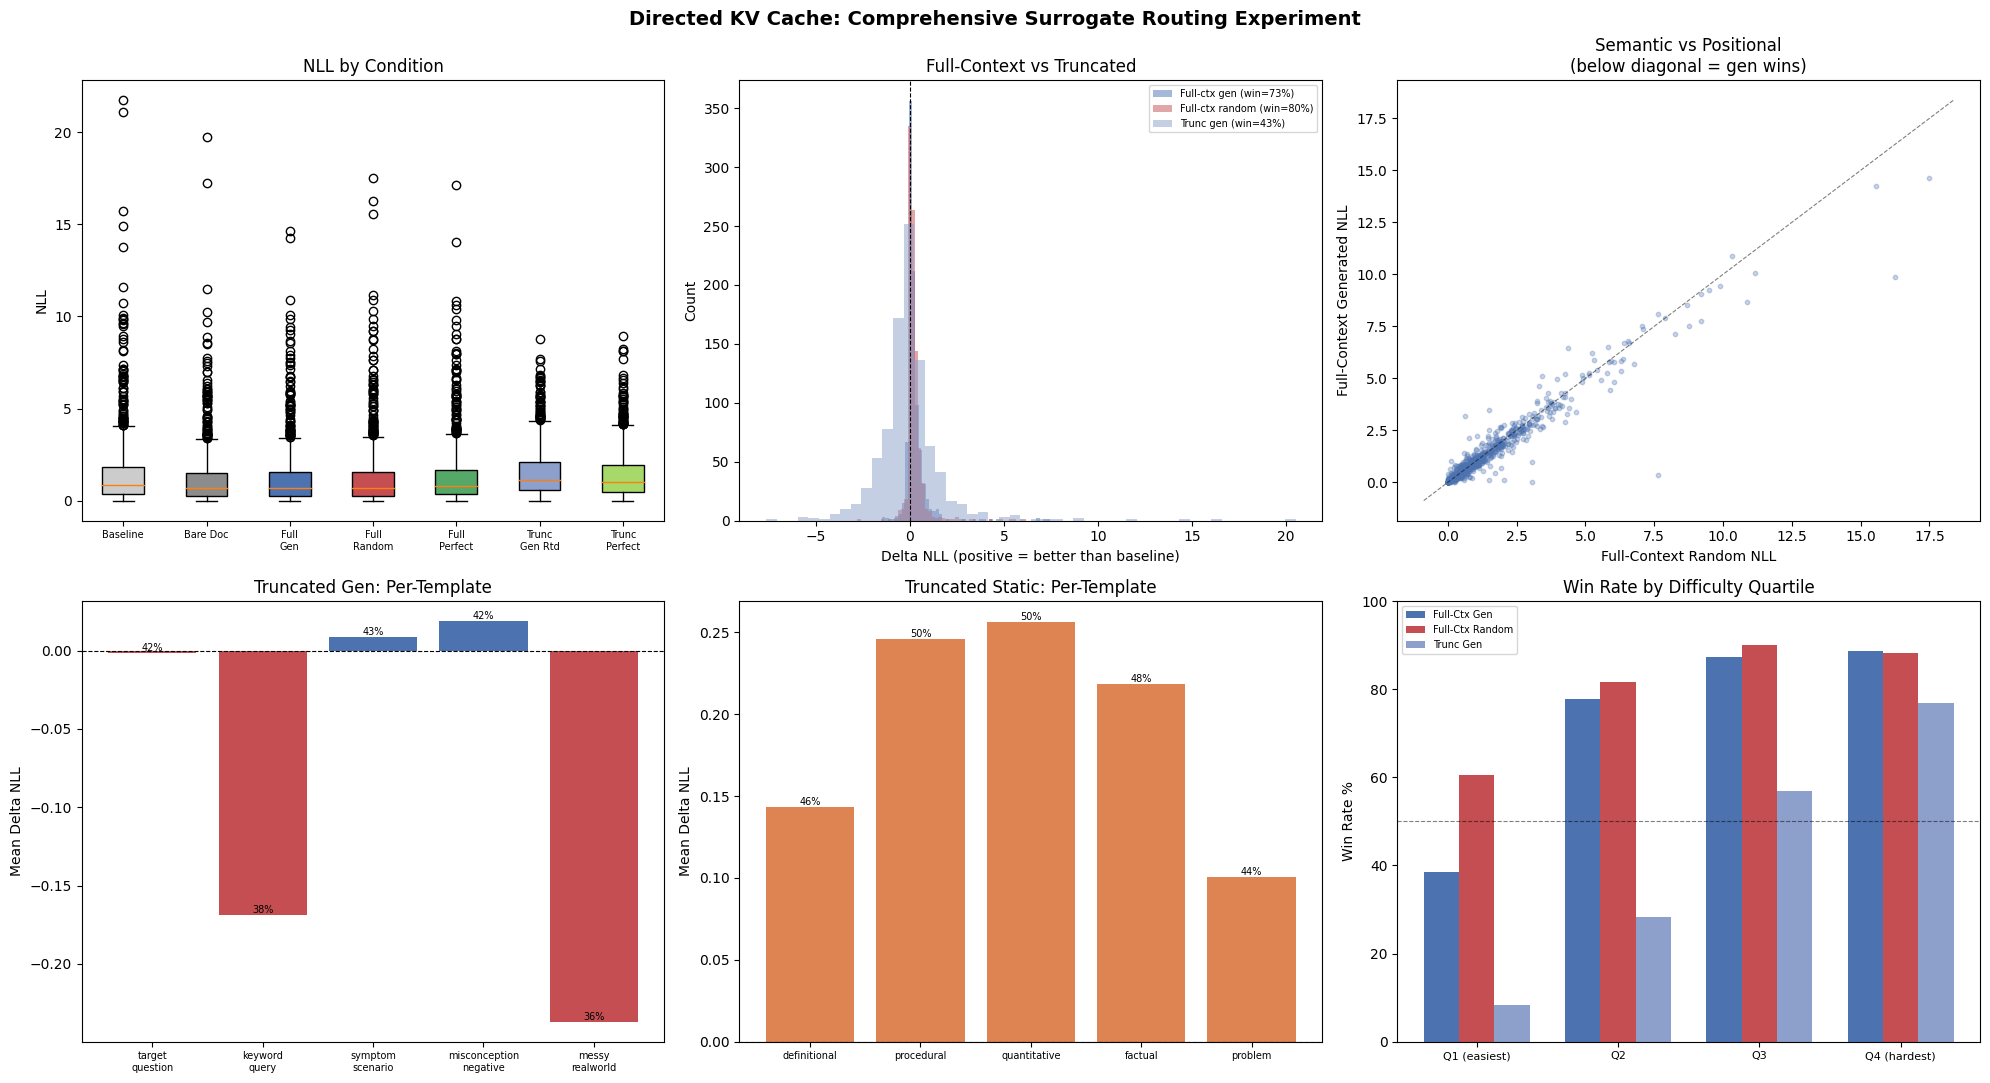

Saved: corrected_truncated_routing_results.png


In [19]:
fig, axes = plt.subplots(2, 3, figsize=(20, 11))
fig.suptitle(
    'Directed KV Cache: Comprehensive Surrogate Routing Experiment',
    fontsize=14, fontweight='bold'
)

# --- Plot 1: All conditions NLL comparison ---
ax = axes[0, 0]
cond_labels = ['Baseline', 'Bare Doc', 'Full\nGen', 'Full\nRandom', 'Full\nPerfect',
               'Trunc\nGen Rtd', 'Trunc\nPerfect']
cond_data = [
    np.array([r['baseline_nll'] for r in results]),
    np.array([r['bare_nll'] for r in results]),
    np.array([r['full_gen_nll'] for r in results]),
    np.array([r['full_random_nll'] for r in results]),
    np.array([r['full_perfect_nll'] for r in results]),
    np.array([r['gen_routed_nll'] for r in results]),
    np.array([r['perfect_nll'] for r in results]),
]
cond_colors = ['#cccccc', '#8c8c8c', '#4c72b0', '#c44e52', '#55a868', '#8da0cb', '#a6d96a']
bp = ax.boxplot(cond_data, labels=cond_labels, patch_artist=True)
for patch, c in zip(bp['boxes'], cond_colors):
    patch.set_facecolor(c)
ax.set_ylabel('NLL')
ax.set_title('NLL by Condition')
ax.tick_params(axis='x', rotation=0, labelsize=7)

# --- Plot 2: Full-context vs Truncated delta distributions ---
ax = axes[0, 1]
delta_full_gen = np.array([r['delta_full_gen'] for r in results])
delta_full_random = np.array([r['delta_full_random'] for r in results])
delta_trunc_gen = np.array([r['delta_gen_routed'] for r in results])
ax.hist(delta_full_gen, bins=50, alpha=0.5,
        label=f'Full-ctx gen (win={np.mean(delta_full_gen>0)*100:.0f}%)', color='#4c72b0')
ax.hist(delta_full_random, bins=50, alpha=0.5,
        label=f'Full-ctx random (win={np.mean(delta_full_random>0)*100:.0f}%)', color='#c44e52')
ax.hist(delta_trunc_gen, bins=50, alpha=0.5,
        label=f'Trunc gen (win={np.mean(delta_trunc_gen>0)*100:.0f}%)', color='#8da0cb')
ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_xlabel('Delta NLL (positive = better than baseline)')
ax.set_ylabel('Count')
ax.set_title('Full-Context vs Truncated')
ax.legend(fontsize=7)

# --- Plot 3: Semantic vs Positional scatter ---
ax = axes[0, 2]
ax.scatter(
    [r['full_random_nll'] for r in results],
    [r['full_gen_nll'] for r in results],
    alpha=0.3, s=10, c='#4c72b0'
)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Full-Context Random NLL')
ax.set_ylabel('Full-Context Generated NLL')
ax.set_title('Semantic vs Positional\n(below diagonal = gen wins)')

# --- Plot 4: Per-template mean delta (generated, truncated) ---
ax = axes[1, 0]
gen_keys = list(analysis['gen_template_stats'].keys())
gen_means = [analysis['gen_template_stats'][k]['mean_delta'] for k in gen_keys]
gen_wins = [analysis['gen_template_stats'][k]['win_rate'] * 100 for k in gen_keys]
bar_colors = ['#4c72b0' if d > 0 else '#c44e52' for d in gen_means]
bars = ax.bar(range(len(gen_keys)), gen_means, color=bar_colors)
ax.set_xticks(range(len(gen_keys)))
ax.set_xticklabels([k.replace('_', '\n') for k in gen_keys], fontsize=7)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_ylabel('Mean Delta NLL')
ax.set_title('Truncated Gen: Per-Template')
for i, (bar, wr) in enumerate(zip(bars, gen_wins)):
    ax.text(i, bar.get_height(), f'{wr:.0f}%', ha='center', va='bottom', fontsize=7)

# --- Plot 5: Per-template mean delta (static, truncated) ---
ax = axes[1, 1]
static_keys = list(analysis['static_template_stats'].keys())
static_means = [analysis['static_template_stats'][k]['mean_delta'] for k in static_keys]
static_wins = [analysis['static_template_stats'][k]['win_rate'] * 100 for k in static_keys]
bar_colors_s = ['#dd8452' if d > 0 else '#c44e52' for d in static_means]
bars = ax.bar(range(len(static_keys)), static_means, color=bar_colors_s)
ax.set_xticks(range(len(static_keys)))
ax.set_xticklabels([k.replace('static_', '').replace('_', '\n') for k in static_keys], fontsize=7)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_ylabel('Mean Delta NLL')
ax.set_title('Truncated Static: Per-Template')
for i, (bar, wr) in enumerate(zip(bars, static_wins)):
    ax.text(i, bar.get_height(), f'{wr:.0f}%', ha='center', va='bottom', fontsize=7)

# --- Plot 6: Win rate by baseline quartile (full-ctx vs truncated) ---
ax = axes[1, 2]
q_labels = []
q_full_gen_wr = []
q_full_random_wr = []
q_trunc_gen_wr = []
for label, cond in bins:
    subset = [r for r in results if cond(r['baseline_nll'])]
    if not subset:
        continue
    q_labels.append(label)
    q_full_gen_wr.append(np.mean([r['delta_full_gen'] > 0 for r in subset]) * 100)
    q_full_random_wr.append(np.mean([r['delta_full_random'] > 0 for r in subset]) * 100)
    q_trunc_gen_wr.append(np.mean([r['delta_gen_routed'] > 0 for r in subset]) * 100)

x_pos = np.arange(len(q_labels))
w = 0.25
ax.bar(x_pos - w, q_full_gen_wr, w, label='Full-Ctx Gen', color='#4c72b0')
ax.bar(x_pos, q_full_random_wr, w, label='Full-Ctx Random', color='#c44e52')
ax.bar(x_pos + w, q_trunc_gen_wr, w, label='Trunc Gen', color='#8da0cb')
ax.axhline(50, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(q_labels, fontsize=8)
ax.set_ylabel('Win Rate %')
ax.set_title('Win Rate by Difficulty Quartile')
ax.legend(fontsize=7)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('results/exp04/corrected_truncated_routing_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: corrected_truncated_routing_results.png')


## Step 12: Save Results

In [20]:
# Serialize results to JSON
output = {
    'metadata': {
        'experiment': 'corrected_truncated_cache_routing',
        'description': (
            'Surrogate-primed KV cache with truncation and RoPE position correction. '
            '5 LLM-generated + 5 static surrogates per document, '
            'with similarity-based routing and oracle selection.'
        ),
        'timestamp': datetime.datetime.now().isoformat(),
        'model_name': config.model_name,
        'num_samples_requested': config.num_samples,
        'num_samples_evaluated': len(results),
        'num_skipped': skipped,
        'num_errors': errors,
        'elapsed_seconds': elapsed_total,
        'seed': config.seed,
        'min_passage_words': config.min_passage_words,
        'max_passage_words': config.max_passage_words,
        'surrogate_max_tokens': config.surrogate_max_tokens,
        'surrogate_temperature': config.surrogate_temperature,
    },
    'analysis': {
        k: (v if not isinstance(v, np.floating) else float(v))
        for k, v in analysis.items()
        if k not in ('gen_template_stats', 'static_template_stats')
    },
    'gen_template_stats': {
        k: {sk: float(sv) if isinstance(sv, np.floating) else sv for sk, sv in v.items()}
        for k, v in analysis['gen_template_stats'].items()
    },
    'static_template_stats': {
        k: {sk: float(sv) if isinstance(sv, np.floating) else sv for sk, sv in v.items()}
        for k, v in analysis['static_template_stats'].items()
    },
    'results': results,
}

output_path = 'results/exp04/corrected_truncated_routing_results.json'
with open(output_path, 'w') as f:
    json.dump(output, f, indent=2, default=str)
print(f"Results saved to {output_path}")
print(f"File size: {os.path.getsize(output_path) / 1e6:.1f} MB")

Results saved to corrected_truncated_routing_results.json
File size: 3.2 MB


## Step 13: Conclusions

In [21]:
print('=' * 80)
print('CONCLUSIONS')
print('=' * 80)

print(f'\nSamples evaluated: {len(results)} (skipped {skipped}, errors {errors})')
print(f'\nBaseline (Document:\\n{{doc}}) mean NLL: {analysis["mean_baseline_nll"]:.4f}')

# Bare doc
bare_mean = np.mean([r['bare_nll'] for r in results])
bare_wr = np.mean([r['delta_bare'] > 0 for r in results]) * 100
t_bare, p_bare = stats.ttest_rel(baseline_arr, np.array([r['bare_nll'] for r in results]))
print(f'\n--- Bare Document (no framing) ---')
print(f'  Mean NLL: {bare_mean:.4f}  (win rate: {bare_wr:.1f}%, p={p_bare:.4f})')

# Full context conditions
for label, nll_key in [('Full-Ctx Gen (routed)', 'full_gen_nll'),
                        ('Full-Ctx Static (routed)', 'full_static_nll'),
                        ('Full-Ctx Perfect (query)', 'full_perfect_nll'),
                        ('Full-Ctx Random Prefix', 'full_random_nll')]:
    arr = np.array([r[nll_key] for r in results])
    delta = baseline_arr - arr
    t, p = stats.ttest_rel(baseline_arr, arr)
    wr = np.mean(delta > 0) * 100
    print(f'\n--- {label} ---')
    print(f'  Mean NLL: {np.mean(arr):.4f}  (win rate: {wr:.1f}%, p={p:.4f})')

# Truncated conditions
perfect_mean = np.mean([r['perfect_nll'] for r in results])
perfect_wr = np.mean([r['delta_perfect'] > 0 for r in results]) * 100
print(f'\n--- Trunc+Corr Perfect (actual query) ---')
print(f'  Mean NLL: {perfect_mean:.4f}  (win rate: {perfect_wr:.1f}%, p={p_perfect:.4f})')

print(f'\n--- Trunc+Corr Generated (routed) ---')
print(f'  Mean NLL: {analysis["mean_gen_routed_nll"]:.4f}  (win rate: {analysis["win_rate_gen_routed"]*100:.1f}%, p={analysis["p_value_gen_routed"]:.4f})')

print(f'\n--- Trunc+Corr Static (routed) ---')
print(f'  Mean NLL: {analysis["mean_static_routed_nll"]:.4f}  (win rate: {analysis["win_rate_static_routed"]*100:.1f}%, p={analysis["p_value_static_routed"]:.4f})')

# Key interpretations
full_gen_mean = np.mean([r['full_gen_nll'] for r in results])
full_random_mean = np.mean([r['full_random_nll'] for r in results])
t_sem, p_sem = stats.ttest_rel(
    np.array([r['full_gen_nll'] for r in results]),
    np.array([r['full_random_nll'] for r in results])
)

print(f'\n{"=" * 80}')
print('KEY FINDINGS')
print('=' * 80)

trunc_gen_mean = analysis['mean_gen_routed_nll']
bl_mean = analysis['mean_baseline_nll']

print(f'\n1. TRUNCATED + CORRECTED vs BASELINE:')
if analysis['p_value_gen_routed'] < 0.05 and trunc_gen_mean < bl_mean:
    print('   Truncated+corrected caches significantly beat baseline.')
else:
    print('   Truncated+corrected caches do NOT significantly beat baseline.')
    print('   RoPE correction neutralizes truncation damage but preserves no semantic benefit.')

print(f'\n2. FULL-CONTEXT vs BASELINE:')
t_fc, p_fc = stats.ttest_rel(baseline_arr, np.array([r['full_gen_nll'] for r in results]))
if p_fc < 0.05 and full_gen_mean < bl_mean:
    print(f'   Full-context generated surrogates significantly improve over baseline (p={p_fc:.4f}).')
else:
    print(f'   Full-context generated surrogates do NOT significantly improve (p={p_fc:.4f}).')

print(f'\n3. SEMANTIC vs POSITIONAL (full-ctx gen vs full-ctx random):')
if p_sem < 0.05:
    if full_gen_mean < full_random_mean:
        print(f'   Generated > random (p={p_sem:.4f}): benefit has a SEMANTIC component.')
    else:
        print(f'   Random >= generated (p={p_sem:.4f}): benefit is POSITIONAL, not semantic.')
else:
    print(f'   No significant difference (p={p_sem:.4f}): benefit appears POSITIONAL.')

print(f'\n4. BARE DOCUMENT:')
if p_bare < 0.05 and bare_mean < bl_mean:
    print(f'   Bare doc (no framing) is significantly better than framed baseline (p={p_bare:.4f}).')
    print('   The "Document:\\n" framing text itself slightly hurts performance.')

print('\n' + '=' * 80)


CONCLUSIONS

Samples evaluated: 921 (skipped 79, errors 0)

Baseline (Document:\n{doc}) mean NLL: 1.5054

--- Bare Document (no framing) ---
  Mean NLL: 1.2054  (win rate: 74.5%, p=0.0000)

--- Full-Ctx Gen (routed) ---
  Mean NLL: 1.2430  (win rate: 73.1%, p=0.0000)

--- Full-Ctx Static (routed) ---
  Mean NLL: 1.2891  (win rate: 71.3%, p=0.0000)

--- Full-Ctx Perfect (query) ---
  Mean NLL: 1.3378  (win rate: 64.9%, p=0.0000)

--- Full-Ctx Random Prefix ---
  Mean NLL: 1.2778  (win rate: 80.1%, p=0.0000)

--- Trunc+Corr Perfect (actual query) ---
  Mean NLL: 1.4251  (win rate: 44.3%, p=0.1811)

--- Trunc+Corr Generated (routed) ---
  Mean NLL: 1.5289  (win rate: 42.6%, p=0.7012)

--- Trunc+Corr Static (routed) ---
  Mean NLL: 1.3139  (win rate: 48.0%, p=0.0019)

KEY FINDINGS

1. TRUNCATED + CORRECTED vs BASELINE:
   Truncated+corrected caches do NOT significantly beat baseline.
   RoPE correction neutralizes truncation damage but preserves no semantic benefit.

2. FULL-CONTEXT vs BAS